In [531]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import torch
import torchvision
import torchvision.datasets as dsets             #for downloading dataset
import torchvision.transforms as transforms      #for transforming dataset into tensors

from torch import nn
from torch.autograd import Variable
import torchvision.transforms.functional as fn

from sklearn.model_selection import train_test_split

from PIL import Image

from time import time

## Importing Data

In [532]:
data = pd.read_csv('double_pendulum_data.csv', sep=',')
display(data.head(24))

data = data.to_numpy()


,theta_1,theta_2,dtheta_1,dtheta_2
0,-0.136273,-2.354292,3.269050,4.259279
1,-0.104119,-2.311299,3.158434,4.338537
2,-0.073172,-2.267539,3.027628,4.412529
3,-0.043633,-2.223066,2.876737,4.481144
4,-0.015703,-2.177934,2.706071,4.544425
5,0.010424,-2.132195,2.516133,4.602587
6,0.034558,-2.085898,2.307608,4.656024
7,0.056517,-2.039088,2.081324,4.705308
8,0.076128,-1.991803,1.838220,4.751197
9,0.093228,-1.944072,1.579290,4.794624


## Train/Test Split Data

In [533]:
data_train, data_test = train_test_split(data, train_size=0.75)

print(data_train.shape)
print(data_test.shape)

(1650, 4)
(550, 4)


In [534]:
# seq_len = 10
device = 'cpu'

Xm  = np.mean(data_train, axis=0)
Xv  = 2*np.std(data_train, axis=0)

# print(Xm.shape)
# print(Xv.shape)

Xm_train = np.tile(Xm,(data_train.shape[0],1))
Xv_train = np.tile(Xv,(data_train.shape[0],1))

# print(Xm_train.shape)
# print(Xv_train.shape)

Xm_test  = np.tile(Xm,(data_test.shape[0],1))
Xv_test  = np.tile(Xv,(data_test.shape[0],1))

data_train = (data_train - Xm_train)/Xv_train
data_test  = (data_test - Xm_test)/Xv_test

X_train, Y_train = data_train[:,:], data_train[:,:]
X_test, Y_test   = data_test[:,:], data_test[:,:]

print(X_train.shape)
print(Y_train.shape)

x_train, y_train = torch.from_numpy(X_train).float().to(device), torch.from_numpy(Y_train).float().to(device)
x_test, y_test   = torch.from_numpy(X_test).float().to(device), torch.from_numpy(Y_test).float().to(device)

print(x_train.size())
print(y_train.size())

(1650, 4)
(1650, 4)
torch.Size([1650, 4])
torch.Size([1650, 4])


## Convert to Tensors

In [535]:
batch_size = 11
def generate_batch_data(x, y, batch_size):
    for batch, i in enumerate(range(0, len(x), batch_size)):
        x_batch = x[i : i + batch_size-1,:]
        y_batch = y[i+1 : i + batch_size,:]
        yield x_batch, y_batch, batch

In [536]:
for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
    print('batch:',batch)
    print('x_batch size:', x_batch.shape)
    print('y_batch size:', y_batch.shape)

batch: 0
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 1
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 2
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 3
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 4
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 5
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 6
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 7
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 8
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 9
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 10
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 11
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 4])
batch: 12
x_batch size: torch.Size([10, 4])
y_batch size: torch.Size([10, 

## Hyper Parameters

In [537]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 


learning_rate = 0.1

input_size = 4
sequence_length = 1
hidden_size = 10
num_layers = 2
output_size = 4


## Creating NN Model

In [538]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
#         out, _ = self.rnn(x, h0)  
        # or:
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
#         out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        out = out
        return out

model = RNN(input_size, hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


## Check if model works

In [539]:
# sample = training_data[0:10,0:4].reshape(10,1,4)
# output = model(sample)
# print('sample_ip',sample.size())
# print('output_size', output.size())
# print('model works')
# label = training_data[(num_samples*11):(num_samples*11)+10,0:4].reshape(10,1,4)
# print(label.size())

# # predicted_output = model(training_data[(num_samples*11),0:4].reshape(1,1,4))
# loss = criterion(output, training_data[1:11,0:4].reshape(10,1,4))
# print(loss)

## Training

In [540]:
Loss = np.zeros(num_epochs).astype('int32')
start_time = time()
num_samples = 149
num_epochs = 200

for epoch in range(num_epochs):
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
#         print('sahpe x', x_batch.shape)
#         print('sahpe y', y_batch.shape)
        
        predicted_output = model(x_batch.reshape(10,1,4))
        loss = criterion(predicted_output, y_batch.reshape(10,1,4))
        optimizer.zero_grad()
        loss.backward()
#         print(i)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 100)

        ## update model params
        optimizer.step()

    train_running_loss += loss.detach().item()
        
    print('Epoch: %d \t Loss: %.4f \t ' \
             %(epoch, loss ))
#     Loss[epoch] = loss

end_time = time()
print('Total Duration: {}'.format(end_time - start_time))
        
    

Epoch: 0 	 Loss: 7.8279 	 
Epoch: 1 	 Loss: 7.7765 	 
Epoch: 2 	 Loss: 7.8670 	 
Epoch: 3 	 Loss: 7.8342 	 
Epoch: 4 	 Loss: 7.8821 	 
Epoch: 5 	 Loss: 7.8349 	 
Epoch: 6 	 Loss: 7.8453 	 
Epoch: 7 	 Loss: 7.8470 	 
Epoch: 8 	 Loss: 7.8359 	 
Epoch: 9 	 Loss: 7.8366 	 
Epoch: 10 	 Loss: 7.8387 	 
Epoch: 11 	 Loss: 7.8511 	 
Epoch: 12 	 Loss: 7.8343 	 
Epoch: 13 	 Loss: 7.8299 	 
Epoch: 14 	 Loss: 7.8349 	 
Epoch: 15 	 Loss: 7.8347 	 
Epoch: 16 	 Loss: 7.8330 	 
Epoch: 17 	 Loss: 7.7802 	 
Epoch: 18 	 Loss: 7.8347 	 
Epoch: 19 	 Loss: 7.8343 	 
Epoch: 20 	 Loss: 7.8661 	 
Epoch: 21 	 Loss: 7.8447 	 
Epoch: 22 	 Loss: 7.8532 	 
Epoch: 23 	 Loss: 7.8337 	 
Epoch: 24 	 Loss: 7.8345 	 
Epoch: 25 	 Loss: 7.8347 	 
Epoch: 26 	 Loss: 7.8347 	 
Epoch: 27 	 Loss: 7.8346 	 
Epoch: 28 	 Loss: 7.8349 	 
Epoch: 29 	 Loss: 7.8351 	 
Epoch: 30 	 Loss: 7.8350 	 
Epoch: 31 	 Loss: 7.8351 	 
Epoch: 32 	 Loss: 7.8349 	 
Epoch: 33 	 Loss: 7.8345 	 
Epoch: 34 	 Loss: 7.8353 	 
Epoch: 35 	 Loss: 7.8363 	 
Ep

## Testing

In [541]:
loss_batch = []
for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
    predicted_output = model(x_batch.reshape(10,1,4))
    loss = criterion(predicted_output, y_batch.reshape(10,1,4))
    print('Sample: %d \t Loss: %.4f' \
             %(batch, loss ))


end_time = time()
print('Total Duration: {}'.format(end_time - start_time))


Sample: 0 	 Loss: 7.6049
Sample: 1 	 Loss: 8.6917
Sample: 2 	 Loss: 5.3018
Sample: 3 	 Loss: 6.6343
Sample: 4 	 Loss: 4.7847
Sample: 5 	 Loss: 5.2040
Sample: 6 	 Loss: 6.6725
Sample: 7 	 Loss: 5.3917
Sample: 8 	 Loss: 6.4272
Sample: 9 	 Loss: 4.2720
Sample: 10 	 Loss: 6.8821
Sample: 11 	 Loss: 7.7148
Sample: 12 	 Loss: 7.1834
Sample: 13 	 Loss: 6.6920
Sample: 14 	 Loss: 6.1261
Sample: 15 	 Loss: 5.4388
Sample: 16 	 Loss: 7.1759
Sample: 17 	 Loss: 10.5715
Sample: 18 	 Loss: 5.2581
Sample: 19 	 Loss: 4.0771
Sample: 20 	 Loss: 6.5687
Sample: 21 	 Loss: 6.3125
Sample: 22 	 Loss: 6.3383
Sample: 23 	 Loss: 4.3989
Sample: 24 	 Loss: 7.5510
Sample: 25 	 Loss: 7.3582
Sample: 26 	 Loss: 5.9990
Sample: 27 	 Loss: 5.1936
Sample: 28 	 Loss: 6.2914
Sample: 29 	 Loss: 5.8972
Sample: 30 	 Loss: 6.3425
Sample: 31 	 Loss: 7.2617
Sample: 32 	 Loss: 6.3866
Sample: 33 	 Loss: 5.0514
Sample: 34 	 Loss: 7.5515
Sample: 35 	 Loss: 7.6403
Sample: 36 	 Loss: 8.0360
Sample: 37 	 Loss: 5.7391
Sample: 38 	 Loss: 6.

## Plot a test trajectory

In [542]:
x_in = x_batch.detach().numpy()
print(x_in.shape)
y_out = predicted_output.reshape(10,4).detach().numpy()
y_out.shape

(10, 4)


(10, 4)

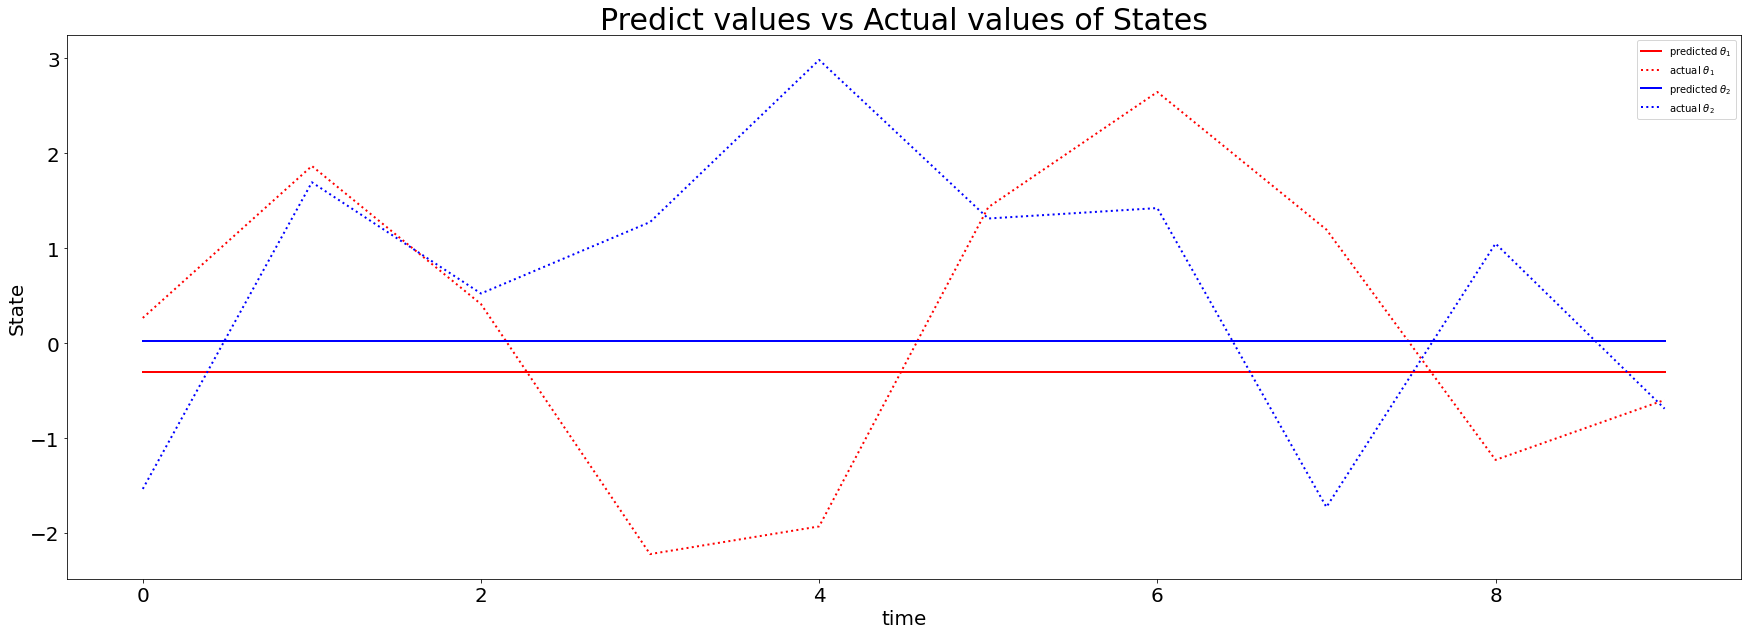

In [550]:
plt.figure(figsize=(30,10))
plt.title('Predict values vs Actual values of States', fontsize=30)
plt.xlabel('time', fontsize=20)
plt.ylabel('State', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(10), y_out[:,0], 'r',      label=r'predicted $\theta_1$', linewidth = 2.0)
plt.plot(np.arange(10), x_in[:,0], 'r' + ':', label=r'actual $\theta_1$', linewidth = 2.0)
plt.plot(np.arange(10), y_out[:,1], 'b',      label=r'predicted $\theta_2$', linewidth = 2.0)
plt.plot(np.arange(10), x_in[:,1], 'b' + ':', label=r'actual $\theta_2$', linewidth = 2.0)
plt.legend()
# plt.legend(['predicted $\theta_1$','actual $\theta_1$','predicted $\theta_2$','actual $\theta_2$'])
# plt.show()
plt.savefig('predicted vs actual.png', dpi=72)
# plt.close()